# This notebook demonstrates plotting various MCS track statistics between OBS and Model

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from scipy import fftpack
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
%matplotlib inline

In [2]:
# Select a region (Amazon, Argentina)
region = 'Amazon'
# region = 'Argentina'

# Min number of MCS to plot
min_ntracks = 10

# MCS lifetime limits
lifetime_bounds = [2,60]

# Define region bounds
box_arg = [-68,-50,-40,-20]
box_amz = [-75,-40,-20,5]
# Months to include
months_amz = [1,2,3,4,10,11,12]
months_arg = [1,2,3,10,11,12]

# Lookup region based on input
bounds_dict = {'Argentina':box_arg, 'Amazon':box_amz}
months_dict = {'Argentina':months_arg, 'Amazon':months_amz}
bounds = bounds_dict[region]
months = months_dict[region]
print(f'{region} lat/lon bounds: {bounds}')
print(f'{region} months: {months}')

Amazon lat/lon bounds: [-75, -40, -20, 5]
Amazon months: [1, 2, 3, 4, 10, 11, 12]


In [3]:
# Specify years to include in the statistics
years = [2010, 2015, 2018]

# Sepcify directory of the MCS track stats file
rootdir = '/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/'
gpmfiles = []
wrffiles = []
for yy in years:
    gpmfiles = gpmfiles + sorted(glob.glob(f'{rootdir}GPM/stats/mcs_tracks_final_{yy}*.nc'))
    wrffiles = wrffiles + sorted(glob.glob(f'{rootdir}WRF/stats/mcs_tracks_final_{yy}*.nc'))
nyears_obs = len(gpmfiles)
nyears_wrf = len(wrffiles)
print(f'Number of years (OBS): {nyears_obs}')
print(f'Number of years (WRF): {nyears_wrf}')

figdir = f'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

Number of years (OBS): 3
Number of years (WRF): 3
/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/


In [4]:
# Read OBS data
dsobs = xr.open_mfdataset(gpmfiles, concat_dim='tracks', combine='nested').load()
# Renumber the tracks so they are unique
ntracks_obs = dsobs.dims['tracks']
dsobs['tracks'] = np.arange(0, ntracks_obs)
pixel_radius_obs = dsobs.attrs['pixel_radius_km']
# dsobs

In [5]:
# Read wrf data
dsm1 = xr.open_mfdataset(wrffiles, concat_dim='tracks', combine='nested').load()
# Renumber the tracks so they are unique
ntracks_wrf = dsm1.dims['tracks']
dsm1['tracks'] = np.arange(0, ntracks_wrf)
pixel_radius_m1 = dsm1.attrs['pixel_radius_km']
# Convert longitudes from 0~360 to -180~+180
dsm1['meanlon'] = ((dsm1.meanlon - 180) % 360) - 180
dsm1['pf_lon'] = ((dsm1.pf_lon - 180) % 360) - 180
dsm1['pf_lon_centroid'] = ((dsm1.pf_lon_centroid - 180) % 360) - 180
dsm1['pf_lon_weightedcentroid'] = ((dsm1.pf_lon_weightedcentroid - 180) % 360) - 180
# dsm1

## Function to find tracks initiated within a specified region, month, and lifetime range

In [6]:
def find_track_in_region(times, lons, lats, lifetime, lon_bounds, lat_bounds, lifetime_bounds, smonth_vals):
    
    # Get the track initiation month and location
    start_month = times.isel(times=0).dt.month
    start_lon = lons.isel(times=0)
    start_lat = lats.isel(times=0)

    # Find tracks that initiates within a region
    mcsidx = np.where(
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)) & \
        (np.in1d(start_month, smonth_vals))
        # (start_month >= min(smonth_bounds)) & (start_month <= max(smonth_bounds))
    )[0]
    print('Number of MCS: ', len(mcsidx))
    return mcsidx

In [7]:
# start_month = dsobs.base_time.isel(times=0).dt.month
# smonth_vals = np.array([3, 4, 5])
# # np.intersect1d(start_month, smonth_vals)
# np.count_nonzero(np.in1d(start_month, smonth_vals))

In [8]:
# Get time resolution of data
time_res_obs = dsobs.attrs['time_resolution_hour']
time_res_m1 = dsm1.attrs['time_resolution_hour']
# Convert track duration to physical lifetime
lifetime_obs = dsobs.track_duration * time_res_obs
lifetime_m1 = dsm1.track_duration * time_res_obs

# Subset MCS by region and lifetime
lon_bounds = [bounds[0],bounds[1]]
lat_bounds = [bounds[2],bounds[3]]
# lon_bounds, lat_bounds
mcsidx_obs = find_track_in_region(dsobs.base_time, dsobs.meanlon, dsobs.meanlat, lifetime_obs, lon_bounds, lat_bounds, lifetime_bounds, months)
mcsidx_m1 = find_track_in_region(dsm1.base_time, dsm1.meanlon, dsm1.meanlat, lifetime_m1, lon_bounds, lat_bounds, lifetime_bounds, months)

Number of MCS:  5614
Number of MCS:  4526


(array([ 884.,  854., 1002.,  865.,    0.,    0.,    0.,    0.,    0.,
         578., 1431.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <BarContainer object of 11 artists>)

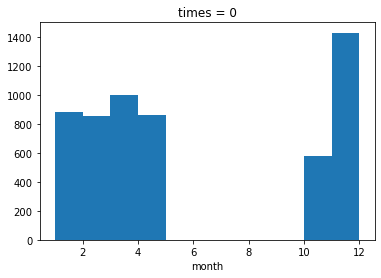

In [9]:
# Check the distribution of tracks by month
dsobs.base_time.dt.month.isel(tracks=mcsidx_obs, times=0).plot.hist(bins=np.arange(1,13,1))

## Subset variables for the selected tracks (OBS)

In [10]:
stime_obs = dsobs.base_time.isel(times=0, tracks=mcsidx_obs)
syear_obs = stime_obs.dt.year
smonth_obs = stime_obs.dt.month
shour_obs = stime_obs.dt.hour

ccslifetime_obs = dsobs.track_duration.isel(tracks=mcsidx_obs) * time_res_obs
lifetime_obs = dsobs.pf_lifetime.isel(tracks=mcsidx_obs)
ccsarea_obs = dsobs.ccs_area.isel(tracks=mcsidx_obs)
ccsdiam_obs = 2 * np.sqrt(ccsarea_obs / np.pi)
mintb_obs = dsobs.corecold_mintb.isel(tracks=mcsidx_obs)
mcsstatus_obs = dsobs.pf_mcsstatus.isel(tracks=mcsidx_obs)
pflon_obs = dsobs.pf_lon.isel(tracks=mcsidx_obs, nmaxpf=0)
pflat_obs = dsobs.pf_lat.isel(tracks=mcsidx_obs, nmaxpf=0)
pfarea_obs = dsobs.pf_area.isel(tracks=mcsidx_obs, nmaxpf=0)
pfdiam_obs = 2 * np.sqrt(pfarea_obs / np.pi)
maxpfdiam_obs = pfdiam_obs.max(dim='times')
startstatus_obs = dsobs.start_status.isel(tracks=mcsidx_obs)
endstatus_obs = dsobs.end_status.isel(tracks=mcsidx_obs)
start_split_cloudnumber_obs = dsobs.start_split_cloudnumber.isel(tracks=mcsidx_obs)
end_merge_cloudnumber_obs = dsobs.end_merge_cloudnumber.isel(tracks=mcsidx_obs)
speed_obs = dsobs.movement_speed.isel(tracks=mcsidx_obs)

pfrainrate_obs = dsobs.pf_rainrate.isel(tracks=mcsidx_obs, nmaxpf=0)
pfaccumrain_obs = dsobs.pf_accumrain.isel(tracks=mcsidx_obs).sum(dim='nmaxpf')
maxpfrainrate_obs = pfrainrate_obs.max(dim='times')
meanpfrainrate_obs = pfrainrate_obs.mean(dim='times')

# Compute volume rainrate [unit: kg/h]
pfvolrain_obs = (dsobs.total_rain * pixel_radius_obs**2).isel(tracks=mcsidx_obs)
pfvolrainheavy_obs = (dsobs.total_heavyrain * pixel_radius_obs**2).isel(tracks=mcsidx_obs)

landfrac_obs = dsobs.pf_landfrac.isel(tracks=mcsidx_obs)
# init_landfrac_obs = landfrac_obs.isel(times=0)
init_landfrac_obs = landfrac_obs.isel(times=slice(0,3)).mean(dim='times')
avg_landfrac_obs = landfrac_obs.mean(dim='times')

## Subset variables for the selected tracks (Model)

In [11]:
stime_m1 = dsm1.base_time.isel(times=0, tracks=mcsidx_m1)
syear_m1 = stime_m1.dt.year
smonth_m1 = stime_m1.dt.month
shour_m1 = stime_m1.dt.hour

ccslifetime_m1 = dsm1.track_duration.isel(tracks=mcsidx_m1) * time_res_m1
lifetime_m1 = dsm1.pf_lifetime.isel(tracks=mcsidx_m1)
ccsarea_m1 = dsm1.ccs_area.isel(tracks=mcsidx_m1)
ccsdiam_m1 = 2 * np.sqrt(ccsarea_m1 / np.pi)
mintb_m1 = dsm1.corecold_mintb.isel(tracks=mcsidx_m1)
mcsstatus_m1 = dsm1.pf_mcsstatus.isel(tracks=mcsidx_m1)
pflon_m1 = dsm1.pf_lon.isel(tracks=mcsidx_m1, nmaxpf=0)
pflat_m1 = dsm1.pf_lat.isel(tracks=mcsidx_m1, nmaxpf=0)
pfarea_m1 = dsm1.pf_area.isel(tracks=mcsidx_m1, nmaxpf=0)
pfdiam_m1 = 2 * np.sqrt(pfarea_m1 / np.pi)
maxpfdiam_m1 = pfdiam_m1.max(dim='times')
startstatus_m1 = dsm1.start_status.isel(tracks=mcsidx_m1)
endstatus_m1 = dsm1.end_status.isel(tracks=mcsidx_m1)
start_split_cloudnumber_m1 = dsm1.start_split_cloudnumber.isel(tracks=mcsidx_m1)
end_merge_cloudnumber_m1 = dsm1.end_merge_cloudnumber.isel(tracks=mcsidx_m1)
speed_m1 = dsm1.movement_speed.isel(tracks=mcsidx_m1)

pfrainrate_m1 = dsm1.pf_rainrate.isel(tracks=mcsidx_m1, nmaxpf=0)
pfaccumrain_m1 = dsm1.pf_accumrain.isel(tracks=mcsidx_m1).sum(dim='nmaxpf')
maxpfrainrate_m1 = pfrainrate_m1.max(dim='times')
meanpfrainrate_m1 = pfrainrate_m1.mean(dim='times')

# Compute volume rainrate [unit: kg/h]
pfvolrain_m1 = (dsm1.total_rain * pixel_radius_m1**2).isel(tracks=mcsidx_m1)
pfvolrainheavy_m1 = (dsm1.total_heavyrain * pixel_radius_m1**2).isel(tracks=mcsidx_m1)

landfrac_m1 = dsm1.pf_landfrac.isel(tracks=mcsidx_m1)
# init_landfrac_m1 = landfrac_m1.isel(times=0)
init_landfrac_m1 = landfrac_m1.isel(times=slice(0,3)).mean(dim='times')
avg_landfrac_m1 = landfrac_m1.mean(dim='times')

## Use PF land fraction to separate land vs. ocean MCSs (OBS)

In [12]:
# Use initiation location to define land vs. oean
mcsidx_land_obs = np.where(avg_landfrac_obs > 0.8)[0]
mcsidx_ocean_obs = np.where(avg_landfrac_obs < 0.2)[0]
nmcs_land_obs = len(mcsidx_land_obs)
nmcs_ocean_obs = len(mcsidx_ocean_obs)

print(f'Number of land MCS (OBS): {nmcs_land_obs}, Number of ocean MCS (OBS): {nmcs_ocean_obs}')

bt_land_obs = dsobs.base_time.isel(tracks=mcsidx_land_obs)
stime_land_obs = stime_obs.isel(tracks=mcsidx_land_obs)
syear_land_obs = stime_land_obs.dt.year
smonth_land_obs = stime_land_obs.dt.month
shour_land_obs = stime_land_obs.dt.hour

pflandfrac_land_obs = landfrac_obs.isel(tracks=mcsidx_land_obs)
ccsarea_land_obs = ccsarea_obs.isel(tracks=mcsidx_land_obs)
ccsdiam_land_obs = ccsdiam_obs.isel(tracks=mcsidx_land_obs)
mintb_land_obs = mintb_obs.isel(tracks=mcsidx_land_obs)
mcsstatus_land_obs = mcsstatus_obs.isel(tracks=mcsidx_land_obs)
pflon_land_obs = pflon_obs.isel(tracks=mcsidx_land_obs)
pflat_land_obs = pflat_obs.isel(tracks=mcsidx_land_obs)
ccslifetime_land_obs = ccslifetime_obs.isel(tracks=mcsidx_land_obs)
lifetime_land_obs = lifetime_obs.isel(tracks=mcsidx_land_obs)
pfarea_land_obs = pfarea_obs.isel(tracks=mcsidx_land_obs)
pfdiam_land_obs = pfdiam_obs.isel(tracks=mcsidx_land_obs)
pfrainrate_land_obs = pfrainrate_obs.isel(tracks=mcsidx_land_obs)
pfaccumrain_land_obs = pfaccumrain_obs.isel(tracks=mcsidx_land_obs)
maxpfdiam_land_obs = maxpfdiam_obs.isel(tracks=mcsidx_land_obs)
maxpfrainrate_land_obs = maxpfrainrate_obs.isel(tracks=mcsidx_land_obs)
meanpfrainrate_land_obs = meanpfrainrate_obs.isel(tracks=mcsidx_land_obs)
startstatus_land_obs = startstatus_obs.isel(tracks=mcsidx_land_obs)
endstatus_land_obs = endstatus_obs.isel(tracks=mcsidx_land_obs)
startsplit_cloudnumber_land_obs = start_split_cloudnumber_obs.isel(tracks=mcsidx_land_obs)
endmerge_cloudnumber_land_obs = end_merge_cloudnumber_obs.isel(tracks=mcsidx_land_obs)
pfvolrain_land_obs = pfvolrain_obs.isel(tracks=mcsidx_land_obs)
pfvolrainheavy_land_obs = pfvolrainheavy_obs.isel(tracks=mcsidx_land_obs)
speed_land_obs = speed_obs.isel(tracks=mcsidx_land_obs)

bt_ocean_obs = dsobs.base_time.isel(tracks=mcsidx_ocean_obs)
stime_ocean_obs = stime_obs.isel(tracks=mcsidx_ocean_obs)
syear_ocean_obs = stime_ocean_obs.dt.year
smonth_ocean_obs = stime_ocean_obs.dt.month
shour_ocean_obs = stime_ocean_obs.dt.hour

pflandfrac_ocean_obs = landfrac_obs.isel(tracks=mcsidx_ocean_obs)
ccsarea_ocean_obs = ccsarea_obs.isel(tracks=mcsidx_ocean_obs)
ccsdiam_ocean_obs = ccsdiam_obs.isel(tracks=mcsidx_ocean_obs)
mintb_ocean_obs = mintb_obs.isel(tracks=mcsidx_ocean_obs)
mcsstatus_ocean_obs = mcsstatus_obs.isel(tracks=mcsidx_ocean_obs)
pflon_ocean_obs = pflon_obs.isel(tracks=mcsidx_ocean_obs)
pflat_ocean_obs = pflat_obs.isel(tracks=mcsidx_ocean_obs)
ccslifetime_ocean_obs = ccslifetime_obs.isel(tracks=mcsidx_ocean_obs)
lifetime_ocean_obs = lifetime_obs.isel(tracks=mcsidx_ocean_obs)
pfarea_ocean_obs = pfarea_obs.isel(tracks=mcsidx_ocean_obs)
pfdiam_ocean_obs = pfdiam_obs.isel(tracks=mcsidx_ocean_obs)
pfrainrate_ocean_obs = pfrainrate_obs.isel(tracks=mcsidx_ocean_obs)
pfaccumrain_ocean_obs = pfaccumrain_obs.isel(tracks=mcsidx_ocean_obs)
maxpfdiam_ocean_obs = maxpfdiam_obs.isel(tracks=mcsidx_ocean_obs)
maxpfrainrate_ocean_obs = maxpfrainrate_obs.isel(tracks=mcsidx_ocean_obs)
meanpfrainrate_ocean_obs = meanpfrainrate_obs.isel(tracks=mcsidx_ocean_obs)
startstatus_ocean_obs = startstatus_obs.isel(tracks=mcsidx_ocean_obs)
endstatus_ocean_obs = endstatus_obs.isel(tracks=mcsidx_ocean_obs)
startsplit_cloudnumber_ocean_obs = start_split_cloudnumber_obs.isel(tracks=mcsidx_ocean_obs)
endmerge_cloudnumber_ocean_obs = end_merge_cloudnumber_obs.isel(tracks=mcsidx_ocean_obs)
pfvolrain_ocean_obs = pfvolrain_obs.isel(tracks=mcsidx_ocean_obs)
pfvolrainheavy_ocean_obs = pfvolrainheavy_obs.isel(tracks=mcsidx_ocean_obs)
speed_ocean_obs = speed_obs.isel(tracks=mcsidx_ocean_obs)

Number of land MCS (OBS): 5254, Number of ocean MCS (OBS): 138


In [13]:
# Use initiation location to define land vs. oean
mcsidx_land_m1 = np.where(init_landfrac_m1 > 0.8)[0]
mcsidx_ocean_m1 = np.where(init_landfrac_m1 < 0.2)[0]
nmcs_land_m1 = len(mcsidx_land_m1)
nmcs_ocean_m1 = len(mcsidx_ocean_m1)

print(f'Number of land MCS (WRF): {nmcs_land_m1}, Number of ocean MCS (WRF): {nmcs_ocean_m1}')

bt_land_m1 = dsm1.base_time.isel(tracks=mcsidx_land_m1)
stime_land_m1 = stime_m1.isel(tracks=mcsidx_land_m1)
syear_land_m1 = stime_land_m1.dt.year
smonth_land_m1 = stime_land_m1.dt.month
shour_land_m1 = stime_land_m1.dt.hour

pflandfrac_land_m1 = landfrac_m1.isel(tracks=mcsidx_land_m1)
ccsarea_land_m1 = ccsarea_m1.isel(tracks=mcsidx_land_m1)
ccsdiam_land_m1 = ccsdiam_m1.isel(tracks=mcsidx_land_m1)
mintb_land_m1 = mintb_m1.isel(tracks=mcsidx_land_m1)
mcsstatus_land_m1 = mcsstatus_m1.isel(tracks=mcsidx_land_m1)
pflon_land_m1 = pflon_m1.isel(tracks=mcsidx_land_m1)
pflat_land_m1 = pflat_m1.isel(tracks=mcsidx_land_m1)
ccslifetime_land_m1 = ccslifetime_m1.isel(tracks=mcsidx_land_m1)
lifetime_land_m1 = lifetime_m1.isel(tracks=mcsidx_land_m1)
pfarea_land_m1 = pfarea_m1.isel(tracks=mcsidx_land_m1)
pfdiam_land_m1 = pfdiam_m1.isel(tracks=mcsidx_land_m1)
pfrainrate_land_m1 = pfrainrate_m1.isel(tracks=mcsidx_land_m1)
pfaccumrain_land_m1 = pfaccumrain_m1.isel(tracks=mcsidx_land_m1)
maxpfdiam_land_m1 = maxpfdiam_m1.isel(tracks=mcsidx_land_m1)
maxpfrainrate_land_m1 = maxpfrainrate_m1.isel(tracks=mcsidx_land_m1)
meanpfrainrate_land_m1 = meanpfrainrate_m1.isel(tracks=mcsidx_land_m1)
startstatus_land_m1 = startstatus_m1.isel(tracks=mcsidx_land_m1)
endstatus_land_m1 = endstatus_m1.isel(tracks=mcsidx_land_m1)
startsplit_cloudnumber_land_m1 = start_split_cloudnumber_m1.isel(tracks=mcsidx_land_m1)
endmerge_cloudnumber_land_m1 = end_merge_cloudnumber_m1.isel(tracks=mcsidx_land_m1)
pfvolrain_land_m1 = pfvolrain_m1.isel(tracks=mcsidx_land_m1)
pfvolrainheavy_land_m1 = pfvolrainheavy_m1.isel(tracks=mcsidx_land_m1)
speed_land_m1 = speed_m1.isel(tracks=mcsidx_land_m1)

bt_ocean_m1 = dsm1.base_time.isel(tracks=mcsidx_ocean_m1)
stime_ocean_m1 = stime_m1.isel(tracks=mcsidx_ocean_m1)
syear_ocean_m1 = stime_ocean_m1.dt.year
smonth_ocean_m1 = stime_ocean_m1.dt.month
shour_ocean_m1 = stime_ocean_m1.dt.hour

pflandfrac_ocean_m1 = landfrac_m1.isel(tracks=mcsidx_ocean_m1)
ccsarea_ocean_m1 = ccsarea_m1.isel(tracks=mcsidx_ocean_m1)
ccsdiam_ocean_m1 = ccsdiam_m1.isel(tracks=mcsidx_ocean_m1)
mintb_ocean_m1 = mintb_m1.isel(tracks=mcsidx_ocean_m1)
mcsstatus_ocean_m1 = mcsstatus_m1.isel(tracks=mcsidx_ocean_m1)
pflon_ocean_m1 = pflon_m1.isel(tracks=mcsidx_ocean_m1)
pflat_ocean_m1 = pflat_m1.isel(tracks=mcsidx_ocean_m1)
ccslifetime_ocean_m1 = ccslifetime_m1.isel(tracks=mcsidx_ocean_m1)
lifetime_ocean_m1 = lifetime_m1.isel(tracks=mcsidx_ocean_m1)
pfarea_ocean_m1 = pfarea_m1.isel(tracks=mcsidx_ocean_m1)
pfdiam_ocean_m1 = pfdiam_m1.isel(tracks=mcsidx_ocean_m1)
pfrainrate_ocean_m1 = pfrainrate_m1.isel(tracks=mcsidx_ocean_m1)
pfaccumrain_ocean_m1 = pfaccumrain_m1.isel(tracks=mcsidx_ocean_m1)
maxpfdiam_ocean_m1 = maxpfdiam_m1.isel(tracks=mcsidx_ocean_m1)
maxpfrainrate_ocean_m1 = maxpfrainrate_m1.isel(tracks=mcsidx_ocean_m1)
meanpfrainrate_ocean_m1 = meanpfrainrate_m1.isel(tracks=mcsidx_ocean_m1)
startstatus_ocean_m1 = startstatus_m1.isel(tracks=mcsidx_ocean_m1)
endstatus_ocean_m1 = endstatus_m1.isel(tracks=mcsidx_ocean_m1)
startsplit_cloudnumber_ocean_m1 = start_split_cloudnumber_m1.isel(tracks=mcsidx_ocean_m1)
endmerge_cloudnumber_ocean_m1 = end_merge_cloudnumber_m1.isel(tracks=mcsidx_ocean_m1)
pfvolrain_ocean_m1 = pfvolrain_m1.isel(tracks=mcsidx_ocean_m1)
pfvolrainheavy_ocean_m1 = pfvolrainheavy_m1.isel(tracks=mcsidx_ocean_m1)
speed_ocean_m1 = speed_m1.isel(tracks=mcsidx_ocean_m1)

Number of land MCS (WRF): 4382, Number of ocean MCS (WRF): 61


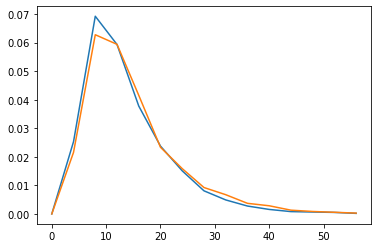

In [14]:
life_bins = np.arange(0, 60.1, 4)
binrange = (0, 60)
pdf_lifetime_land_obs, bins = np.histogram(lifetime_land_obs, bins=life_bins, range=binrange, density=True)
pdf_lifetime_ocean_obs, bins = np.histogram(lifetime_ocean_obs, bins=life_bins, range=binrange, density=True)

pdf_lifetime_land_m1, bins = np.histogram(lifetime_land_m1, bins=life_bins, range=binrange, density=True)
pdf_lifetime_ocean_m1, bins = np.histogram(lifetime_ocean_m1, bins=life_bins, range=binrange, density=True)
plt.plot(life_bins[:-1], pdf_lifetime_land_obs)
plt.plot(life_bins[:-1], pdf_lifetime_land_m1)

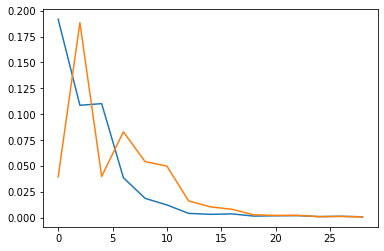

In [15]:
speed_bins = np.arange(0, 30.1, 2)
binrange = (0, 30)
pdf_speed_land_obs, bins = np.histogram(speed_land_obs.where(mcsstatus_land_obs == 1), bins=speed_bins, range=binrange, density=True)
pdf_speed_land_m1, bins = np.histogram(speed_land_m1.where(mcsstatus_land_m1 == 1), bins=speed_bins, range=binrange, density=True)
plt.plot(speed_bins[:-1], pdf_speed_land_obs)
plt.plot(speed_bins[:-1], pdf_speed_land_m1)

## Function to compute 1D KDE

In [16]:
def get_kde1d(data, bins, kde_bw, kde_kernel='gaussian'):
    """
    Compute 1D KDE using Ski-learn
    
    Args:
        data: np.array
            Array containing data.
        bins: np.array
            Desired bins for plotting.
        kde_bw: float
            The bandwidth of the kernel.
        kde_kernel: string
            The kernel to use.
            
    Return:
        kde_out: np.array
            KDE at the desired bins.
    """
    # Flatten array to 1D
    data1d = data.flatten()
    # Remove NaN (sklearn KDE does not handle NaN), and make a new axis
    _data = data1d[~np.isnan(data1d)][:, np.newaxis]
    _bins = bins[:, np.newaxis]
    
    # Estimate 1D KDE following sklearn example
    # https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
    kde = KernelDensity(kernel=kde_kernel, bandwidth=kde_bw).fit(_data)
    # Get KDE values based on input bins
    log_dens = kde.score_samples(_bins)
    # Get linear density
    kde_out = np.exp(log_dens)
    return kde_out

In [17]:
lifetime_bins = np.linspace(0, 60, 1000)
kde_lifetime_obs = get_kde1d(lifetime_land_obs.data, lifetime_bins, kde_bw=3)
kde_lifetime_m1 = get_kde1d(lifetime_land_m1.data, lifetime_bins, kde_bw=3)

In [18]:
speed_bins = np.linspace(0, 30, 1000)
kde_speed_obs = get_kde1d(speed_land_obs.where(mcsstatus_land_obs == 1).data, speed_bins, kde_bw=2)
kde_speed_m1 = get_kde1d(speed_land_m1.where(mcsstatus_land_m1 == 1).data, speed_bins, kde_bw=2)

In [19]:
ccsdiam_bins = np.linspace(0, 1000, 1000)
kde_ccsdiam_obs = get_kde1d(ccsdiam_land_obs.where(mcsstatus_land_obs == 1).data, ccsdiam_bins, kde_bw=20)
kde_ccsdiam_m1 = get_kde1d(ccsdiam_land_m1.where(mcsstatus_land_m1 == 1).data, ccsdiam_bins, kde_bw=20)

In [20]:
pfdiam_bins = np.linspace(0, 500, 1000)
kde_pfdiam_obs = get_kde1d(pfdiam_obs.where(mcsstatus_land_obs == 1).data, pfdiam_bins, kde_bw=20)
kde_pfdiam_m1 = get_kde1d(pfdiam_m1.where(mcsstatus_land_m1 == 1).data, pfdiam_bins, kde_bw=20)

## Plot KDE for 4 select parameters

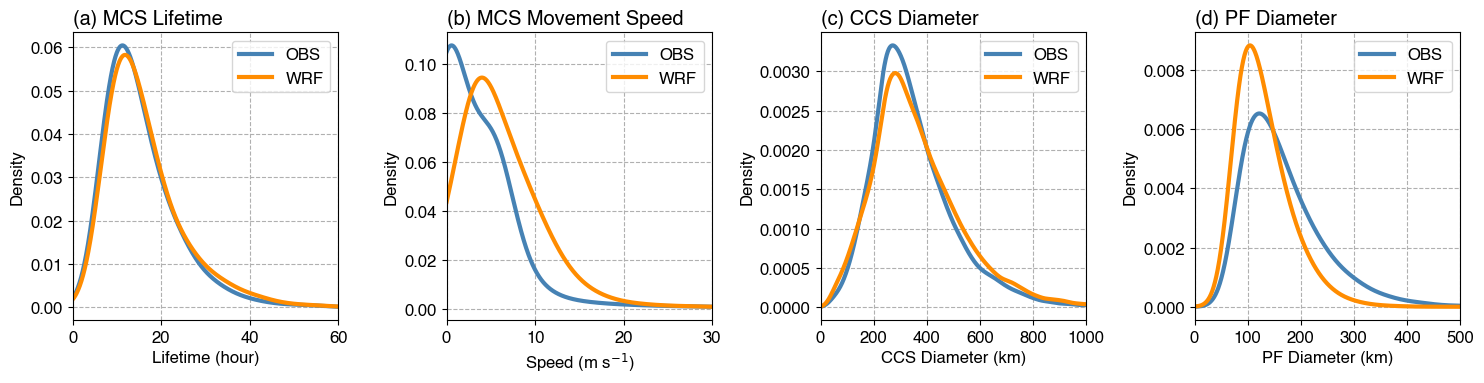

In [21]:
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 4, figsize=(15, 4), dpi=100)

lw = 3
lcolors = {'o':'steelblue', 'm':'darkorange'}
leg_labels = {'o':'OBS', 'm':'WRF'}
ax1 = axes[0]
ax1.plot(lifetime_bins, kde_lifetime_obs, color=lcolors['o'], lw=lw, label=leg_labels['o'])
ax1.plot(lifetime_bins, kde_lifetime_m1, color=lcolors['m'], lw=lw, label=leg_labels['m'])
ax1.set_xlabel('Lifetime (hour)')
ax1.set_ylabel('Density')
ax1.legend()
ax1.set_xlim(0, 60)
ax1.set_title('(a) MCS Lifetime', loc='left')
ax1.grid(ls='--')

ax2 = axes[1]
ax2.plot(speed_bins, kde_speed_obs, color=lcolors['o'], lw=lw, label=leg_labels['o'])
ax2.plot(speed_bins, kde_speed_m1, color=lcolors['m'], lw=lw, label=leg_labels['m'])
ax2.set_xlabel('Speed (m s$^{-1}$)')
ax2.set_ylabel('Density')
ax2.legend()
ax2.set_xlim(0, 30)
ax2.set_title('(b) MCS Movement Speed', loc='left')
ax2.grid(ls='--')

ax3 = axes[2]
ax3.plot(ccsdiam_bins, kde_ccsdiam_obs, color=lcolors['o'], lw=lw, label=leg_labels['o'])
ax3.plot(ccsdiam_bins, kde_ccsdiam_m1, color=lcolors['m'], lw=lw, label=leg_labels['m'])
ax3.set_xlabel('CCS Diameter (km)')
ax3.set_ylabel('Density')
ax3.legend()
ax3.set_xlim(0, 1000)
ax3.set_title('(c) CCS Diameter', loc='left')
ax3.grid(ls='--')

ax4 = axes[3]
ax4.plot(pfdiam_bins, kde_pfdiam_obs, color=lcolors['o'], lw=lw, label=leg_labels['o'])
ax4.plot(pfdiam_bins, kde_pfdiam_m1, color=lcolors['m'], lw=lw, label=leg_labels['m'])
ax4.set_xlabel('PF Diameter (km)')
ax4.set_ylabel('Density')
ax4.legend()
ax4.set_xlim(0, 500)
ax4.set_title('(d) PF Diameter', loc='left')
ax4.grid(ls='--')

fig.tight_layout()
figname = f'{figdir}MCS_1DKDE_Lifetime_Speed_CCSdiam_PFdiam.png'
fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')

## Function to composite track time-evolution by 1 condition

In [26]:
import warnings
def get_comp_tracks_by1cond(in_var, x_cond_var, x_cond_range, start_cn, end_cn, quantiles):
    # Suppress RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        # Filter by one condition, start_split_cloudnumber (start_cn) and end_merge_cloudnumber (end_cn) are both NaN (non-split and non-merge)
        in_var_cond = in_var.where((x_cond_var >= x_cond_range[0]) & (x_cond_var <= x_cond_range[1]) & (~np.isnan(start_cn)) & (~np.isnan(end_cn)), drop=True)
        nsamples = in_var_cond.sizes['tracks']
        out_var_mean = in_var_cond.mean(dim='tracks')
        out_var_qntl = in_var_cond.quantile(quantiles, dim='tracks')
    return out_var_mean, out_var_qntl, nsamples

## Composite time-evolution of MCS parameters by lifetime

In [28]:
quantiles = [0.25, 0.5, 0.75]
lifetime_range1 = [8, 10]
lifetime_range2 = [18, 24]
# Composite track time-evolution by lifetime range
avg1_ccsarea_land_obs, qntl1_ccsarea_land_obs, ns1_land_obs = get_comp_tracks_by1cond(ccsarea_land_obs, ccslifetime_land_obs, lifetime_range1, 
                                                                                      startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)
avg2_ccsarea_land_obs, qntl2_ccsarea_land_obs, ns2_land_obs = get_comp_tracks_by1cond(ccsarea_land_obs, ccslifetime_land_obs, lifetime_range2, 
                                                                                      startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)

avg1_ccsarea_land_m1, qntl1_ccsarea_land_m1, ns1_land_m1 = get_comp_tracks_by1cond(ccsarea_land_m1, ccslifetime_land_m1, lifetime_range1, 
                                                                                    startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)
avg2_ccsarea_land_m1, qntl2_ccsarea_land_m1, ns2_land_m1 = get_comp_tracks_by1cond(ccsarea_land_m1, ccslifetime_land_m1, lifetime_range2, 
                                                                                    startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)
print(f'Sample number (range1): {ns1_land_obs} (OBS), {ns1_land_m1} (WRF)')
print(f'Sample number (range2): {ns2_land_obs} (OBS), {ns2_land_m1} (WRF)')

Sample number (range1): 153 (OBS), 93 (WRF)
Sample number (range2): 99 (OBS), 50 (WRF)


In [29]:
avg1_mintb_land_obs, qntl1_mintb_land_obs, ns1_land_obs = get_comp_tracks_by1cond(mintb_land_obs, ccslifetime_land_obs, lifetime_range1, 
                                                                                  startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)
avg2_mintb_land_obs, qntl2_mintb_land_obs, ns2_land_obs = get_comp_tracks_by1cond(mintb_land_obs, ccslifetime_land_obs, lifetime_range2, 
                                                                                  startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)

avg1_mintb_land_m1, qntl1_mintb_land_m1, ns1_land_m1 = get_comp_tracks_by1cond(mintb_land_m1, ccslifetime_land_m1, lifetime_range1, 
                                                                               startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)
avg2_mintb_land_m1, qntl2_mintb_land_m1, ns2_land_m1 = get_comp_tracks_by1cond(mintb_land_m1, ccslifetime_land_m1, lifetime_range2, 
                                                                               startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)

In [30]:
avg1_pfarea_land_obs, qntl1_pfarea_land_obs, ns1_land_obs = get_comp_tracks_by1cond(pfarea_land_obs, ccslifetime_land_obs, lifetime_range1, 
                                                                                    startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)
avg2_pfarea_land_obs, qntl2_pfarea_land_obs, ns2_land_obs = get_comp_tracks_by1cond(pfarea_land_obs, ccslifetime_land_obs, lifetime_range2, 
                                                                                    startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)

avg1_pfarea_land_m1, qntl1_pfarea_land_m1, ns1_land_m1 = get_comp_tracks_by1cond(pfarea_land_m1, ccslifetime_land_m1, lifetime_range1, 
                                                                                  startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)
avg2_pfarea_land_m1, qntl2_pfarea_land_m1, ns2_land_m1 = get_comp_tracks_by1cond(pfarea_land_m1, ccslifetime_land_m1, lifetime_range2, 
                                                                                  startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)

In [31]:
avg1_pfdiam_land_obs, qntl1_pfdiam_land_obs, ns1_land_obs = get_comp_tracks_by1cond(pfdiam_land_obs, ccslifetime_land_obs, lifetime_range1, 
                                                                                    startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)
avg2_pfdiam_land_obs, qntl2_pfdiam_land_obs, ns2_land_obs = get_comp_tracks_by1cond(pfdiam_land_obs, ccslifetime_land_obs, lifetime_range2, 
                                                                                    startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)

avg1_pfdiam_land_m1, qntl1_pfdiam_land_m1, ns1_land_m1 = get_comp_tracks_by1cond(pfdiam_land_m1, ccslifetime_land_m1, lifetime_range1, 
                                                                                  startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)
avg2_pfdiam_land_m1, qntl2_pfdiam_land_m1, ns2_land_m1 = get_comp_tracks_by1cond(pfdiam_land_m1, ccslifetime_land_m1, lifetime_range2, 
                                                                                  startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)

In [32]:
avg1_pfrainrate_land_obs, qntl1_pfrainrate_land_obs, ns1_land_obs = get_comp_tracks_by1cond(pfrainrate_land_obs, ccslifetime_land_obs, lifetime_range1, 
                                                                                            startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)
avg2_pfrainrate_land_obs, qntl2_pfrainrate_land_obs, ns2_land_obs = get_comp_tracks_by1cond(pfrainrate_land_obs, ccslifetime_land_obs, lifetime_range2, 
                                                                                            startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)

avg1_pfrainrate_land_m1, qntl1_pfrainrate_land_m1, ns1_land_m1 = get_comp_tracks_by1cond(pfrainrate_land_m1, ccslifetime_land_m1, lifetime_range1, 
                                                                                          startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)
avg2_pfrainrate_land_m1, qntl2_pfrainrate_land_m1, ns2_land_m1 = get_comp_tracks_by1cond(pfrainrate_land_m1, ccslifetime_land_m1, lifetime_range2, 
                                                                                          startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)

In [33]:
avg1_pfvolrain_land_obs, qntl1_pfvolrain_land_obs, ns1_land_obs = get_comp_tracks_by1cond(pfvolrain_land_obs, ccslifetime_land_obs, lifetime_range1, 
                                                                                          startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)
avg2_pfvolrain_land_obs, qntl2_pfvolrain_land_obs, ns2_land_obs = get_comp_tracks_by1cond(pfvolrain_land_obs, ccslifetime_land_obs, lifetime_range2, 
                                                                                          startsplit_cloudnumber_land_obs, endmerge_cloudnumber_land_obs, quantiles)

avg1_pfvolrain_land_m1, qntl1_pfvolrain_land_m1, ns1_land_m1 = get_comp_tracks_by1cond(pfvolrain_land_m1, ccslifetime_land_m1, lifetime_range1, 
                                                                                        startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)
avg2_pfvolrain_land_m1, qntl2_pfvolrain_land_m1, ns2_land_m1 = get_comp_tracks_by1cond(pfvolrain_land_m1, ccslifetime_land_m1, lifetime_range2, 
                                                                                        startsplit_cloudnumber_land_m1, endmerge_cloudnumber_land_m1, quantiles)

## Function to plot composite track time-evolution variables

In [36]:
def plot_evolution_10panels(hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                            titles, xlabels, ylabels, xticks, xlims, ylims, legends, 
                            map_extent, lon_box, lat_box, inset_param, figname,
                            legend_fontsize=11, legend_loc='best'):
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['font.weight'] = 'regular'
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=[10,12], dpi=100)

    colors = {'o':'steelblue', 'm':'darkorange'}

    for row in range(0,5):
        for col in range(0,2): 
            ax = axes[row][col]           
            ax.plot(hours_obs[col], dataavg_obs[row][col], colors['o'], lw=3, label=legends['o'])
            ax.plot(hours_m1[col], dataavg_m1[row][col], colors['m'], lw=3, label=legends['m'])
            ax.fill_between(hours_obs[col], dataqntl_obs[row][col][0], dataqntl_obs[row][col][1], facecolor=colors['o'],  alpha=0.3)
            ax.fill_between(hours_m1[col], dataqntl_m1[row][col][0], dataqntl_m1[row][col][1], facecolor=colors['m'],  alpha=0.3)

            if (row == 0): 
                ax.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax.grid(which='major', ls='--')
            ax.set_title(titles[row][col], loc='left')
            ax.set_xlabel(xlabels[row])
            ax.set_ylabel(ylabels[row])
            ax.set_xticks(xticks[col])
            ax.set_xlim(xlims[col][0], xlims[col][1])
            ax.set_ylim(ylims[row][0], ylims[row][1])
            
            # Plot inset map
            if (row == 0):
                resolution = '110m'
                land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
                ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
                proj = ccrs.PlateCarree(central_longitude=180)
                box_proj = ccrs.PlateCarree(central_longitude=0)
                sub_ax = inset_axes(ax, width=inset_param['width'], height=inset_param['height'], loc=inset_param['loc'],
                                    axes_class=cartopy.mpl.geoaxes.GeoAxes, borderpad=inset_param['borderpad'], 
                                    axes_kwargs=dict(map_projection=proj))
                sub_ax.set_extent(map_extent, crs=box_proj)
                # Add land, coastlines, borders to inset
                sub_ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
                sub_ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
                sub_ax.add_feature(land, facecolor='none', edgecolor='k', zorder=1)
                # Plot a box region in the inset
                box = sgeom.box(minx=lon_box[0], maxx=lon_box[1], miny=lat_box[0], maxy=lat_box[1])
                sub_ax.add_geometries([box], box_proj, facecolor='none', edgecolor='g', lw=2)
                sub_ax.add_geometries([box], box_proj, facecolor='g', edgecolor='none', alpha=0.3)

    fig.tight_layout(w_pad=0.6, h_pad=0.5)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

In [37]:
lon_bounds, lat_bounds, region

([-75, -40], [-20, 5], 'Amazon')

/tmp/ipykernel_53039/364142569.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=0.6, h_pad=0.5)


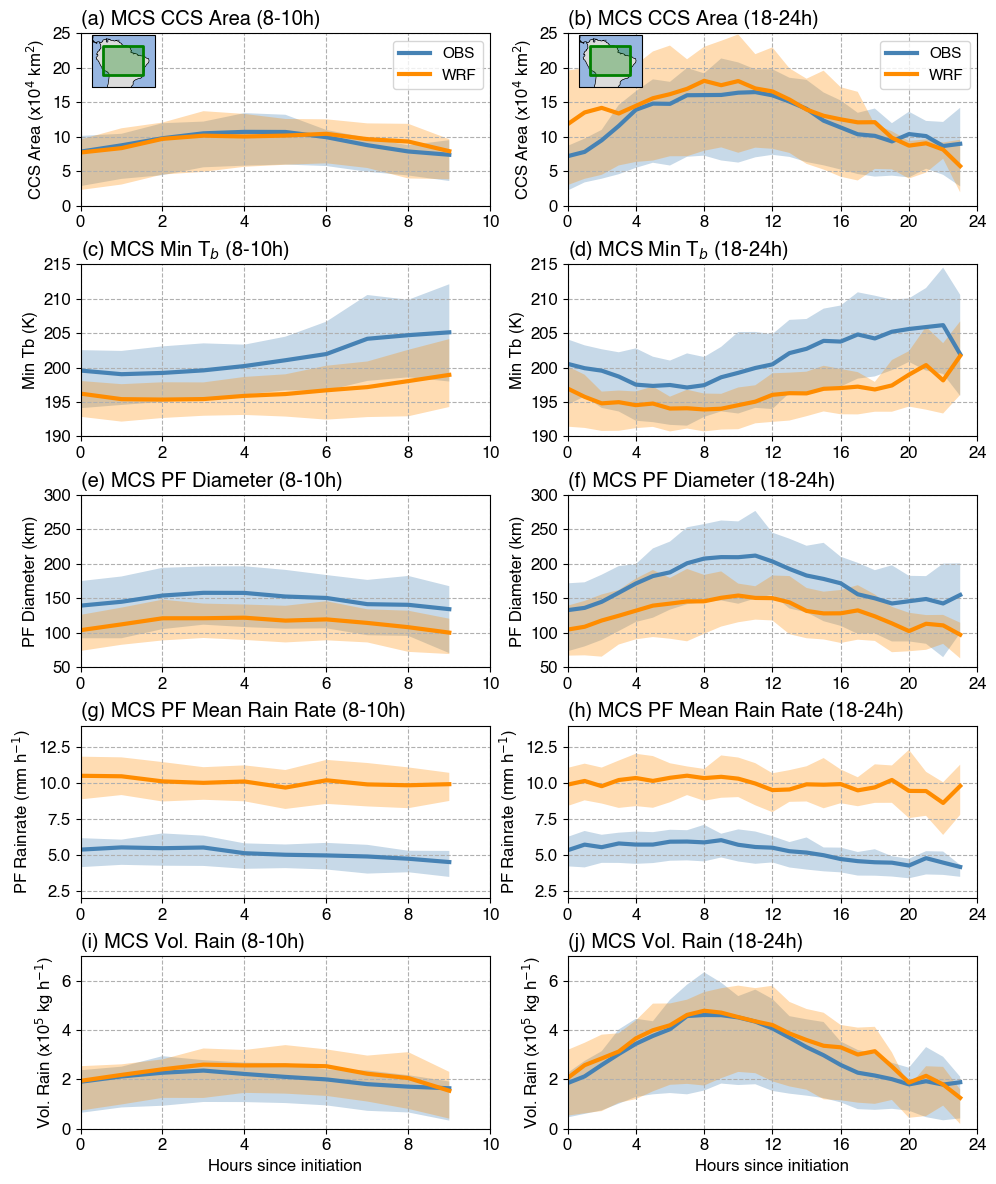

In [38]:
hours_obs = [avg1_ccsarea_land_obs.times, avg2_ccsarea_land_obs.times]
hours_m1 = [avg1_ccsarea_land_m1.times, avg2_ccsarea_land_m1.times]
dataavg_obs = [[avg1_ccsarea_land_obs/1e4, avg2_ccsarea_land_obs/1e4],
            [avg1_mintb_land_obs, avg2_mintb_land_obs],
            [avg1_pfdiam_land_obs, avg2_pfdiam_land_obs], 
            [avg1_pfrainrate_land_obs, avg2_pfrainrate_land_obs],
            [avg1_pfvolrain_land_obs/1e5, avg2_pfvolrain_land_obs/1e5]]
dataavg_m1 = [[avg1_ccsarea_land_m1/1e4, avg2_ccsarea_land_m1/1e4],
            [avg1_mintb_land_m1, avg2_mintb_land_m1],
            [avg1_pfdiam_land_m1, avg2_pfdiam_land_m1], 
            [avg1_pfrainrate_land_m1, avg2_pfrainrate_land_m1],
            [avg1_pfvolrain_land_m1/1e5, avg2_pfvolrain_land_m1/1e5]]
dataqntl_obs = [[(qntl1_ccsarea_land_obs.sel(quantile=0.25)/1e4,qntl1_ccsarea_land_obs.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_land_obs.sel(quantile=0.25)/1e4,qntl2_ccsarea_land_obs.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_land_obs.sel(quantile=0.25),qntl1_mintb_land_obs.sel(quantile=0.75)), 
                 (qntl2_mintb_land_obs.sel(quantile=0.25),qntl2_mintb_land_obs.sel(quantile=0.75))],
                [(qntl1_pfdiam_land_obs.sel(quantile=0.25),qntl1_pfdiam_land_obs.sel(quantile=0.75)), 
                 (qntl2_pfdiam_land_obs.sel(quantile=0.25),qntl2_pfdiam_land_obs.sel(quantile=0.75))],
                [(qntl1_pfrainrate_land_obs.sel(quantile=0.25),qntl1_pfrainrate_land_obs.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_land_obs.sel(quantile=0.25),qntl2_pfrainrate_land_obs.sel(quantile=0.75))],
                [(qntl1_pfvolrain_land_obs.sel(quantile=0.25)/1e5,qntl1_pfvolrain_land_obs.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_land_obs.sel(quantile=0.25)/1e5,qntl2_pfvolrain_land_obs.sel(quantile=0.75)/1e5)],]
dataqntl_m1 = [[(qntl1_ccsarea_land_m1.sel(quantile=0.25)/1e4,qntl1_ccsarea_land_m1.sel(quantile=0.75)/1e4), 
                 (qntl2_ccsarea_land_m1.sel(quantile=0.25)/1e4,qntl2_ccsarea_land_m1.sel(quantile=0.75)/1e4)],
                [(qntl1_mintb_land_m1.sel(quantile=0.25),qntl1_mintb_land_m1.sel(quantile=0.75)), 
                 (qntl2_mintb_land_m1.sel(quantile=0.25),qntl2_mintb_land_m1.sel(quantile=0.75))],
                [(qntl1_pfdiam_land_m1.sel(quantile=0.25),qntl1_pfdiam_land_m1.sel(quantile=0.75)), 
                 (qntl2_pfdiam_land_m1.sel(quantile=0.25),qntl2_pfdiam_land_m1.sel(quantile=0.75))],
                [(qntl1_pfrainrate_land_m1.sel(quantile=0.25),qntl1_pfrainrate_land_m1.sel(quantile=0.75)), 
                 (qntl2_pfrainrate_land_m1.sel(quantile=0.25),qntl2_pfrainrate_land_m1.sel(quantile=0.75))],
                [(qntl1_pfvolrain_land_m1.sel(quantile=0.25)/1e5,qntl1_pfvolrain_land_m1.sel(quantile=0.75)/1e5), 
                 (qntl2_pfvolrain_land_m1.sel(quantile=0.25)/1e5,qntl2_pfvolrain_land_m1.sel(quantile=0.75)/1e5)],]
ns_obs = [ns1_land_obs, ns2_land_obs]
ns_m1 = [ns1_land_m1, ns2_land_m1]
titles = []
titles = [[f'(a) MCS CCS Area ({lifetime_range1[0]}-{lifetime_range1[1]}h)', f'(b) MCS CCS Area ({lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'(c) MCS Min T$_b$ ({lifetime_range1[0]}-{lifetime_range1[1]}h)', f'(d) MCS Min T$_b$ ({lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'(e) MCS PF Diameter ({lifetime_range1[0]}-{lifetime_range1[1]}h)', f'(f) MCS PF Diameter ({lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'(g) MCS PF Mean Rain Rate ({lifetime_range1[0]}-{lifetime_range1[1]}h)', f'(h) MCS PF Mean Rain Rate ({lifetime_range2[0]}-{lifetime_range2[1]}h)'],
          [f'(i) MCS Vol. Rain ({lifetime_range1[0]}-{lifetime_range1[1]}h)', f'(j) MCS Vol. Rain ({lifetime_range2[0]}-{lifetime_range2[1]}h)']]
xlabels = ['','','','','Hours since initiation']
ylabels = ['CCS Area (x10$^{4}$ km$^2$)', 'Min Tb (K)', 'PF Diameter (km)', 'PF Rainrate (mm h$^{-1}$)', 'Vol. Rain (x10$^{5}$ kg h$^{-1}$)', ]
xticks = [np.arange(0, max(lifetime_range1)+1, 2), np.arange(0, max(lifetime_range2)+1, 4)]
xlims = [(0, max(lifetime_range1)), (0, max(lifetime_range2))]
ylims = [(0,25), (190,215), (50,300), (2,14), (0,7)]
legends = {'o':f'OBS', 'm':f'WRF'}
figname = f'{figdir}mcs_composite_evolution_{region}_land.png'

bounds = [lon_bounds[0], lon_bounds[1]-0.1, lat_bounds[0], lat_bounds[1]]
map_extent = [bounds[0]-10,bounds[1]+10,bounds[2]-10,bounds[3]+10]
inset_param = {'width':'20%', 'height':'30%', 'loc':'upper left', 'borderpad':0.1}

fig = plot_evolution_10panels(hours_obs, hours_m1, dataavg_obs, dataqntl_obs, dataavg_m1, dataqntl_m1, ns_obs, ns_m1,  
                              titles, xlabels, ylabels, xticks, xlims, ylims, legends, 
                              map_extent, lon_bounds, lat_bounds, inset_param, figname, legend_loc='upper right')

In [40]:
figdir

'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'

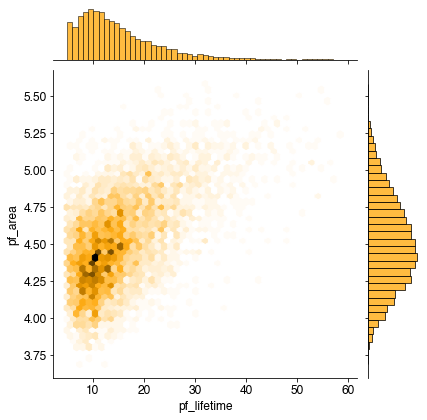

In [39]:
sns.jointplot(x=lifetime_land_obs, y=np.log10(pfarea_land_obs.max(dim='times')), kind="hex", color="orange")

### Set Seaborn plot style (all plot styles after this will be changed)

In [49]:
# Set Seaborn plot style
sns.set_theme('talk', style='whitegrid', font_scale=1.3, 
              rc={'lines.linewidth':5, 'font.family':'Helvetica', 'axes.edgecolor':'k', 'grid.linestyle':'--'})

### Function to truncate colormap

In [50]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [51]:
def plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_loc='lower right'):
    mpl.rcParams['font.family'] = 'Helvetica'
    g = sns.JointGrid(height=8, ratio=5, space=.3, marginal_ticks=False, xlim=xlim, ylim=ylim)

    lcolors = {'obs':'steelblue', 'model':'darkorange'}
    cmap = copy.copy(mpl.cm.get_cmap('Blues'))
    cmap = truncate_colormap(cmap, 0.1, 1)
    sns.kdeplot(x=x_obs, y=y_obs, levels=levels, fill=True, cmap=cmap, alpha=0.9, ax=g.ax_joint)
    sns.kdeplot(x=x_m1, y=y_m1, color=lcolors['model'], levels=levels, fill=False, ax=g.ax_joint)
    sns.kdeplot(x=x_obs, color=lcolors['obs'], ax=g.ax_marg_x)
    sns.kdeplot(x=x_m1, color=lcolors['model'], ax=g.ax_marg_x)
    sns.kdeplot(y=y_obs, color=lcolors['obs'], ax=g.ax_marg_y)
    sns.kdeplot(y=y_m1, color=lcolors['model'], ax=g.ax_marg_y)
    legend_elements = [mpl.patches.Patch(facecolor=lcolors['obs'], edgecolor='b'),
                       mpl.lines.Line2D([0], [0], color=lcolors['model'])]
    legend_labels = ['IMERG', 'WRF']
    leg = mpl.legend.Legend(g.ax_joint, handles=legend_elements, labels=legend_labels, 
                            loc=legend_loc, facecolor='w', prop={'family':'Helvetica', 'size':18})
    g.ax_joint.text(0.95, 0.95, annotate_text, ha='right', va='center', fontsize=22, transform=g.ax_joint.transAxes)
    g.ax_joint.add_artist(leg)
    g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
    g.ax_marg_x.set_ylabel('')
    g.ax_marg_y.set_xlabel('')

    g.savefig(figname, dpi=300, facecolor='w')
    # sns.JointGrid(marginal_ticks=True)
    return g

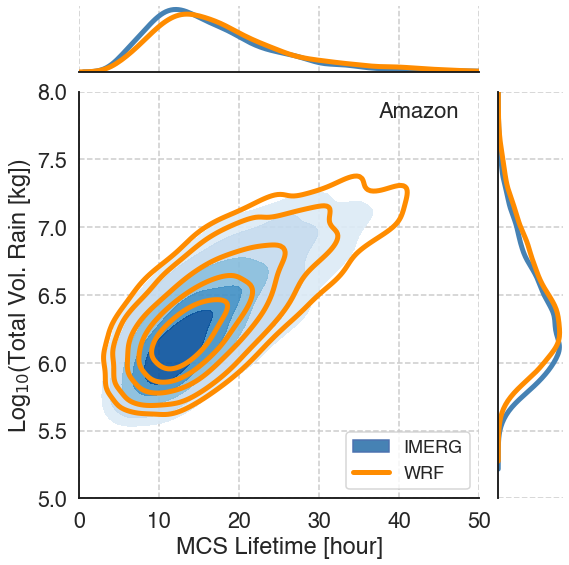

In [52]:
x_obs, y_obs = ccslifetime_land_obs.values, np.log10(pfvolrain_land_obs.sum(dim='times')).values
x_m1, y_m1 = ccslifetime_land_m1.values, np.log10(pfvolrain_land_m1.sum(dim='times')).values
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (0,50)
ylim = (5,8)
xlabel = 'MCS Lifetime [hour]'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
annotate_text = f'{region}'
figname = f'{figdir}JointDist_Lifetime_Totalvolrain_imerg_wrf_{region}.png'
# figname
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname)

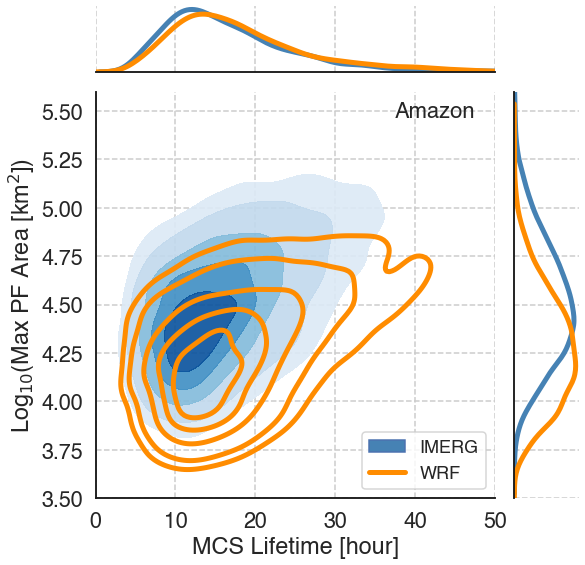

In [53]:
x_obs, y_obs = ccslifetime_land_obs.values, np.log10(pfarea_land_obs.max(dim='times')).values
x_m1, y_m1 = ccslifetime_land_m1.values, np.log10(pfarea_land_m1.max(dim='times')).values
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (0,50)
ylim = (3.5,5.6)
xlabel = 'MCS Lifetime [hour]'
ylabel = 'Log$_{10}$(Max PF Area [km$^2$])'
annotate_text = f'{region}'
figname = f'{figdir}JointDist_Lifetime_PFarea_imerg_wrf_{region}.png'
# figname
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname)

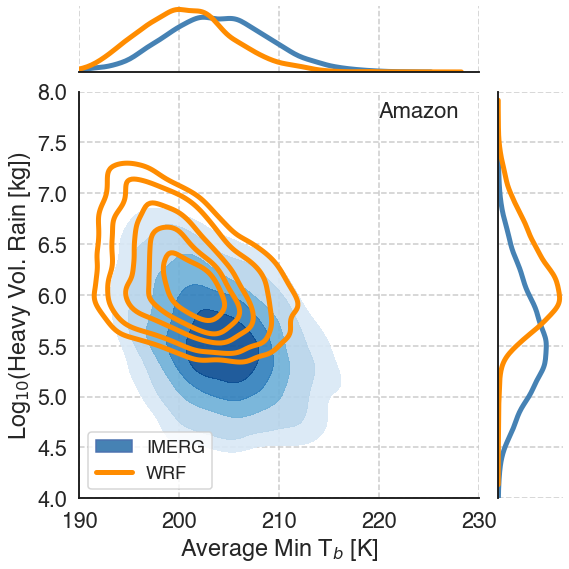

In [54]:
x_obs, y_obs = mintb_land_obs.mean(dim='times').values, np.log10(pfvolrainheavy_land_obs.sum(dim='times')).values
x_m1, y_m1 = mintb_land_m1.mean(dim='times').values, np.log10(pfvolrainheavy_land_m1.sum(dim='times')).values
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (190,230)
ylim = (4.,8)
xlabel = 'Average Min T$_b$ [K]'
ylabel = 'Log$_{10}$(Heavy Vol. Rain [kg])'
annotate_text = f'{region}'
figname = f'{figdir}JointDist_MinTb_HeavyVolrain_imerg_wrf_{region}.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname, legend_loc='lower left')

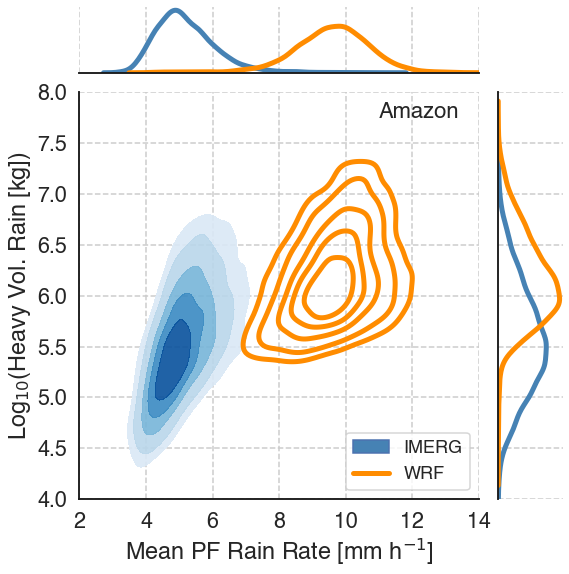

In [55]:
x_obs, y_obs = pfrainrate_land_obs.mean(dim='times').values, np.log10(pfvolrainheavy_land_obs.sum(dim='times')).values
x_m1, y_m1 = pfrainrate_land_m1.mean(dim='times').values, np.log10(pfvolrainheavy_land_m1.sum(dim='times')).values
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (2,14)
ylim = (4,8)
xlabel = 'Mean PF Rain Rate [mm h$^{-1}$]'
ylabel = 'Log$_{10}$(Heavy Vol. Rain [kg])'
annotate_text = f'{region}'
figname = f'{figdir}JointDist_PFrainrate_HeavyVolrain_imerg_wrf_{region}.png'
# figname
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname)

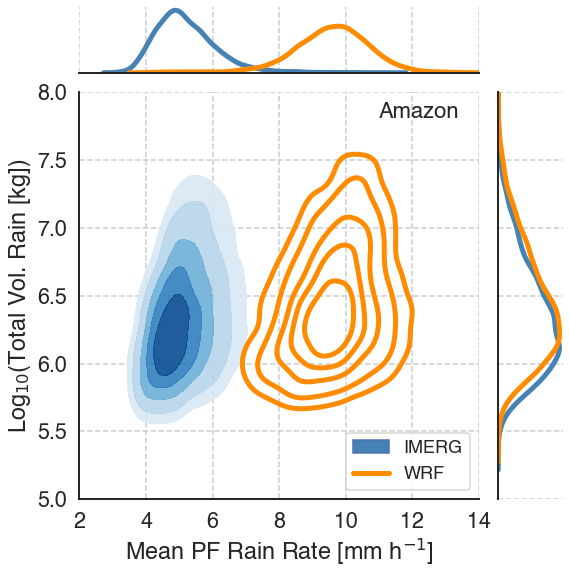

In [56]:
x_obs, y_obs = pfrainrate_land_obs.mean(dim='times').values, np.log10(pfvolrain_land_obs.sum(dim='times')).values
x_m1, y_m1 = pfrainrate_land_m1.mean(dim='times').values, np.log10(pfvolrain_land_m1.sum(dim='times')).values
levels = [0.1,0.2,0.4,0.6,0.8,1]
xlim = (2,14)
ylim = (5.,8)
xlabel = 'Mean PF Rain Rate [mm h$^{-1}$]'
ylabel = 'Log$_{10}$(Total Vol. Rain [kg])'
annotate_text = f'{region}'
figname = f'{figdir}JointDist_PFrainrate_TotalVolrain_imerg_wrf_{region}.png'
g = plot_jointdist(x_obs, y_obs, x_m1, y_m1, levels, xlim, ylim, xlabel, ylabel, annotate_text, figname)

In [57]:
figdir

'/global/cfs/cdirs/m1867/www/PyFLEXTRKR/sample_data/saag/figures/'